# A simple, high-performance tf.data pipeline, with data augmentation

This notebook demonstrates a super simple, readable, and high-performance data pipeline written in tf.data.

It has the following features:

- We can downscale images to save RAM
- The data is loaded in NumPy arrays, and only a single copy of the data is kept in memory, to avoid OOM
- We can train on as many papyruses as we want at once (we sample randomly from one to the other)
- We can iterate over our data either randomly or iteratively (in a grid-like fashion)
- TF-based data augmentation
- Extremely fast!

## Config

In [2]:
import tensorflow as tf
import numpy as np

import random
import gc
import cv2
import time
from tqdm import tqdm


DATA_DIR = "./dataset/"
PATCH_SIZE = 128  # e.g. 128x128
PATCH_HALFSIZE = PATCH_SIZE // 2
DOWNSAMPLING = 0.75  # Setting this to e.g. 0.5 means images will be loaded as 2x smaller. 1 does nothing.
Z_DIM = 40   # Number of slices in the z direction. Max value is 65 - Z_START
Z_START = 0  # Offset of slices in the z direction
BATCH_SIZE = 8

2023-05-17 09:46:15.197688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 09:46:16.220860: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-17 09:46:16.220956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

## Load the training data in CPU RAM as NumPy arrays

In [3]:
def resize(img):
    if DOWNSAMPLING != 1.:
        size = int(img.shape[1] * DOWNSAMPLING), int(img.shape[0] * DOWNSAMPLING)
        img = cv2.resize(img, size)
    return img


def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0)
    img = resize(img)
    return img.astype("bool")


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0)
    img = resize(img)
    return np.expand_dims(img, axis=-1)


def load_volume(split, index):
    # A more memory-efficient volune loader
    fnames = [f"{DATA_DIR}/{split}/{index}/surface_volume/{i:02}.tif"
             for i in range(Z_START, Z_START + Z_DIM)]

    batch_size = 8
    fname_batches = [fnames[i :i + batch_size] for i in range(0, len(fnames), batch_size)]
    volumes = []
    for fname_batch in fname_batches:
        z_slices = []
        for fname in tqdm(fname_batch):
            img = cv2.imread(fname, 0)
            img = resize(img)
            z_slices.append(img)
        volumes.append(np.stack(z_slices, axis=-1))
        del z_slices
    return np.concatenate(volumes, axis=-1)


def load_sample(split, index):
    print(f"Loading '{split}/{index}'...")
    gc.collect()
    if split == "train":
        return load_volume(split, index), load_mask(split, index), load_labels(split, index)
    return load_volume(split, index), load_mask(split, index), None

In [4]:
volume_1, mask_1, labels_1 = load_sample(split="train", index=1)
volume_2, mask_2, labels_2 = load_sample(split="train", index=2)
volume_3, mask_3, labels_3 = load_sample(split="train", index=3)
gc.collect()
print("Loading complete.")

Loading 'train/1'...


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Loading 'train/2'...


100%|██████████| 8/8 [00:19<00:00,  2.49s/it]


Loading 'train/3'...


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Loading complete.


## Define training / validation / production folds

In [5]:
dev_folds = {
    "dev_1": {
        "train_volumes": [volume_1, volume_2],
        "train_labels": [labels_1, labels_2],
        "train_masks": [mask_1, mask_2],
        "validation_volume": volume_3,
        "validation_labels": labels_3,
        "validation_mask": mask_3,
    },
    "dev_2": {
        "train_volumes": [volume_1, volume_3],
        "train_labels": [labels_1, labels_3],
        "train_masks": [mask_1, mask_3],
        "validation_volume": volume_2,
        "validation_labels": labels_2,
        "validation_mask": mask_2,
    },
    "dev_3": {
        "train_volumes": [volume_2, volume_3],
        "train_labels": [labels_2, labels_3],
        "train_masks": [mask_2, mask_3],
        "validation_volume": volume_1,
        "validation_labels": labels_1,
        "validation_mask": mask_1,
    }
}

# prod_data  = {
#     "train_volumes": [volume_1, volume_2, volume_3],
#     "train_labels": [labels_1, labels_2, labels_3],
#     "train_masks": [mask_1, mask_2, mask_3],
# }

## Define data augmentation pipeline

Be mindful that any geometric transformation on the input patches should be replicated on the label patches.

In [6]:
@tf.function
def train_augment_fn(patch, labels):
    patch = tf.image.random_flip_left_right(patch, seed=1337)
    labels = tf.image.random_flip_left_right(labels, seed=1337)
    
    patch = tf.image.random_flip_up_down(patch, seed=42)
    labels = tf.image.random_flip_up_down(labels, seed=42)
    return patch, labels

## Create training & validation datasets that yield patches and their labels

Let's define some utilities for training and validation datasets. It's all super simple, just very short functions composed together.

We have two ways to iterate over the data:

- **Randomly**: We sample random patches within one of multiple volumes. This is what we use for our training data.
- **Iteratively**: We sample patches in a deterministic grid-like pattern that provides us full coverage of the masked area of a given volume. This is what we use for our validation data and our test (production) data.

In [7]:
def sample_random_location(shape):
    x = random.randint(PATCH_HALFSIZE, shape[0] - PATCH_HALFSIZE - 1)
    y = random.randint(PATCH_HALFSIZE, shape[1] - PATCH_HALFSIZE - 1)
    return (x, y)


def list_all_locations(mask, stride=PATCH_HALFSIZE):
    locations = []
    for x in range(PATCH_HALFSIZE, mask.shape[0] - PATCH_HALFSIZE, stride):
        for y in range(PATCH_HALFSIZE, mask.shape[1] - PATCH_HALFSIZE, stride):
            if mask[x, y]:
                locations.append((x, y))
    return locations


def extract_patch(location, volume):
    x = location[0]
    y = location[1]
    patch = volume[x - PATCH_HALFSIZE :x + PATCH_HALFSIZE,
                   y - PATCH_HALFSIZE :y + PATCH_HALFSIZE, :]
    return patch.astype("float32") / 255.


def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    
    label = labels[x - PATCH_HALFSIZE :x + PATCH_HALFSIZE,
                   y - PATCH_HALFSIZE :y + PATCH_HALFSIZE, :]
    return label.astype("float32") / 255.


def make_random_data_generator(volume, mask, labels):
    def data_generator():
        while True:
            loc = sample_random_location(mask.shape)
            if mask[loc[0], loc[1]]:
                patch = extract_patch(loc, volume)
                label = extract_labels(loc, labels)
                yield patch, label
    return data_generator


def make_iterated_data_generator(volume, mask, labels=None):
    locations = list_all_locations(mask)
    def data_generator():
        for loc in locations:
            patch = extract_patch(loc, volume)
            if labels is None:
                yield patch
            else:
                label = extract_labels(loc, labels)
                yield patch, label
    return data_generator
    

def make_tf_dataset(gen_fn, labeled=True):
    if labeled:
        output_signature = (
            tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, Z_DIM), dtype=tf.float32),
            tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        )
    else:
        output_signature = tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, Z_DIM), dtype=tf.float32)
    ds = tf.data.Dataset.from_generator(
        gen_fn,
        output_signature=output_signature,
    )
    return ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

Next, let's prepare a utility that turns a fold's metadata into a training dataset and a validation dataset.

In [8]:
def make_datasets_for_fold(fold, train_augment_fn=None):
    train_volumes = fold["train_volumes"]
    train_masks = fold["train_masks"]
    train_labels = fold["train_labels"]
    
    include_validation = "validation_volume" in fold
    if include_validation:
        validation_volume = fold["validation_volume"]
        validation_mask = fold["validation_mask"]
        validation_labels = fold["validation_labels"]

    all_train_ds = []
    for volume, mask, labels in zip(train_volumes, train_masks, train_labels):
        train_ds = make_tf_dataset(
            make_random_data_generator(volume, mask, labels),
            labeled=True,
        )
        all_train_ds.append(train_ds)
    train_ds = tf.data.Dataset.sample_from_datasets(all_train_ds)

    if train_augment_fn:
        train_ds = train_ds.map(train_augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    if not include_validation:
        return train_ds

    val_ds = make_tf_dataset(
        make_iterated_data_generator(validation_volume, validation_mask, validation_labels),
        labeled=True,
    )
    return train_ds, val_ds

## Check dataset output shapes

In [9]:
# # We use the first fold datasets for this quick check
# train_ds, val_ds = make_datasets_for_fold(dev_folds["dev_1"])

# for patch, label in train_ds.take(1):
#     print(f"Train patch shape: {patch.shape}")
#     print(f"Train label shape: {label.shape}")
# print("-")
# for patch, label in val_ds.take(1):
#     print(f"Val patch shape: {patch.shape}")
#     print(f"Val label shape: {label.shape}")

## Check dataset throughput

It's always a good idea to check that your data pipeline is efficient. You don't want to be CPU-bound at training time!

In this case, our datasets are *insanely* fast because they're compiled to natively parallel C++, rather than using multiprocessing in the Python runtime.

In [10]:
def check_throughout(ds):
    n = 100
    for i, _ in enumerate(ds.take(n + 1)):
        if i == 1:  # Don't include dataset initialization time
            t0 = time.time()
    time_per_batch = (time.time() - t0) / n
    print(f"Time per batch: {time_per_batch:.4f}s")
    print(f"Time per sample: {time_per_batch / BATCH_SIZE:.4f}s")


# train_ds, val_ds = make_datasets_for_fold(dev_folds["dev_1"])

# check_throughout(train_ds)

With data augmentation:

In [11]:
# train_ds, val_ds = make_datasets_for_fold(dev_folds["dev_1"], train_augment_fn=train_augment_fn)

# check_throughout(train_ds)

## Usage examples

Note that the training datasets are infinitely streaming -- iterating over them will just yield new random patches forever.
When using these datasets in `fit()`, make sure to provide the `steps_per_epoch=N` argument to draw N batches per epoch.

In [12]:
# # This is how you create the datasets for a given fold:
# train_ds, val_ds = make_datasets_for_fold(dev_folds["dev_2"], train_augment_fn=train_augment_fn)

# # This is how you create your production training dataset:
# train_ds = make_datasets_for_fold(prod_data, train_augment_fn=train_augment_fn)

# # This is how you create your production test dataset:
# test_volume, test_mask, _ = load_sample(split="test", index="a")
# test_ds = make_tf_dataset(
#     make_iterated_data_generator(test_volume, test_mask),
#     labeled=False,
# )

# # This is how you iterate over the production test dataset
# # and retrieve the locations (x, y) corresponding to the center pixel
# # of the current patch:
# locations_ds = tf.data.Dataset.from_tensor_slices(
#     list_all_locations(test_mask, stride=PATCH_SIZE)
# ).batch(BATCH_SIZE)
# for loc_batch, patch_batch in tqdm(zip(locations_ds, test_ds)):
#     index = 3
#     x, y = loc_batch[index]
#     print(f"Patch patch_batch[{index}] is for location ({x}, {y})")
#     break

In [13]:
# now it's time for a model or sth
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [14]:
# If you need to specify non-standard input shape
model = sm.Unet(
    'resnet50', 
    input_shape=(PATCH_SIZE, PATCH_SIZE, Z_DIM), 
    encoder_weights=None,
    classes=1
)
# model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

2023-05-17 09:49:11.459850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 09:49:11.568471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 09:49:11.568945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 09:49:11.574388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

In [15]:
_, val_ds =  make_datasets_for_fold(dev_folds["dev_1"], train_augment_fn=train_augment_fn)
# test_volume, test_mask, _ = load_sample(split="test", index="a")
# test_ds = make_tf_dataset(
#     make_iterated_data_generator(test_volume, test_mask),
#     labeled=True,
# )
gc.collect()

403

In [16]:
# model.fit(train_ds, batch_size=BATCH_SIZE, epochs=50, steps_per_epoch=50, validation_data=val_ds, validation_steps=50)
# model = tf.keras.models.load_model('naive_unet_with_resnet50', custom_objects=None)
model.load_weights('naive_unet_with_resnet50_weights')

In [17]:
import matplotlib.pyplot as plt
batch = val_ds.take(1)

In [22]:
# res = model.predict(patch)
for x, y in batch:
    print(x.shape)
print(y.shape)

(8, 128, 128, 40)
(8, 128, 128, 1)


NameError: name 'res' is not defined

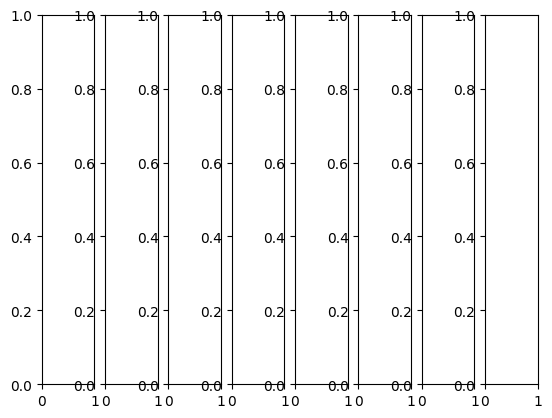

In [19]:
fig, axes = plt.subplots(1, 8)

for r in range(res.shape[0]):
    axes[r].imshow(res[r], cmap='gray')